In [ ]:
!nvidia-smi

Wed Jul 24 13:40:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil

drive_folder_path = '/content/drive/MyDrive/english-handwritten-characters-dataset'
colab_folder_path = '/content/handwritten_text_dataset'


shutil.copytree(drive_folder_path, colab_folder_path)


'/content/handwritten_text_dataset'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dense, Reshape, Embedding, MultiHeadAttention, LayerNormalization, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [ ]:
df= pd.read_csv("/content/handwritten_text_dataset/english.csv")

In [ ]:
df.sample(2)

,image,label
2238,Img/img041-039.png,e
1830,Img/img034-016.png,X


In [ ]:
df.isna().sum().sum(),df.duplicated().sum()

(0, 0)

In [ ]:
df["label"].value_counts()

label
0    55
1    55
2    55
3    55
4    55
     ..
v    55
w    55
x    55
y    55
z    55
Name: count, Length: 62, dtype: int64

In [49]:
images = df["image"]
output = []
for path in images:
    image = Image.open("/content/handwritten_text_dataset/" + path)
    image = image.convert("L")
    image = image.resize((256, 256))
    image = np.array(image)
    output.append(image)

image_data = np.array(output)
image_data = image_data / 255.0  # Normalize images
image_data = np.expand_dims(image_data, axis=-1)  # Add channel dimension
input_image_shape = image_data.shape[1:]  # Shape without batch dimension




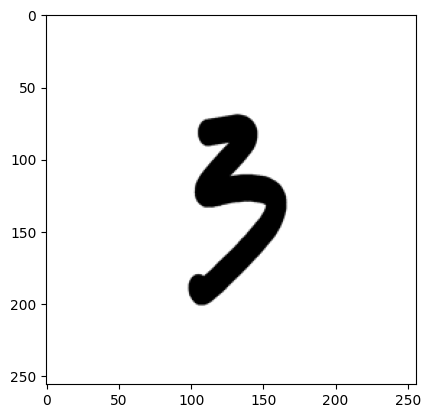

In [ ]:
plt.gray()
plt.imshow(image_data[200].squeeze(), cmap='gray')
plt.show()


In [50]:
text_data = df["label"]
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(text_data)
text_sequences = tokenizer.texts_to_sequences(text_data)
max_text_length = max(len(seq) for seq in text_sequences)
padded_text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_text_length)
vocab_size = len(tokenizer.word_index) + 1

In [51]:
# Define CNN Encoder
def cnn_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # Downsample by a factor of 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # Downsample by a factor of 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # Downsample by a factor of 2
    x = Flatten()(x)
    encoded = Dense(256, activation='relu')(x)
    encoded = Reshape((1, -1))(encoded)  # Reshape to (1, feature_dim)
    return Model(inputs, encoded, name="cnn_encoder")

cnn_encoder_model = cnn_encoder(input_shape=input_image_shape)

In [52]:
def transformer_block(x, num_heads, dff, dropout_rate):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    # Feed Forward Network
    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)

    # Add & Normalize
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Define Transformer Decoder
def transformer_decoder(input_dim, max_text_length, feature_dim):
    inputs = Input(shape=(max_text_length,))
    x = Embedding(input_dim=input_dim, output_dim=64)(inputs)
    for _ in range(2):
        x = transformer_block(x, num_heads=2, dff=128, dropout_rate=0.1)
    x = Dense(feature_dim, activation='relu')(x)
    x = Reshape((max_text_length, feature_dim))(x)
    x = Dense(256 * 256, activation='sigmoid')(x)
    output = Reshape((256, 256, 1))(x[:, 0, :])
    return Model(inputs, output, name="transformer_decoder")

feature_dim = cnn_encoder_model.output_shape[-1]
transformer_decoder_model = transformer_decoder(input_dim=vocab_size, max_text_length=max_text_length, feature_dim=feature_dim)

In [53]:
# Combine Models
image_input = Input(shape=input_image_shape)
encoded_features = cnn_encoder_model(image_input)
text_input = Input(shape=(max_text_length,))
decoded_image = transformer_decoder_model(text_input)
model = Model(inputs=[image_input, text_input], outputs=decoded_image)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 transformer_decoder (Funct  (None, 256, 256, 1)          1696352   ['input_22[0][0]']            
 ional)                                                   0                                       
                                                                                                  
Total params: 16963520 (64.71 MB)
Trainable params: 16963520 (64.71 MB)
Non-trainable params

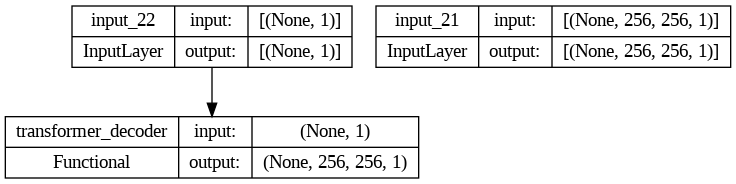

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [55]:
# Training the model
batch_size = 32
epochs = 300
for epoch in range(epochs):
    for batch in range(len(padded_text_sequences) // batch_size):
        idx = np.random.randint(0, len(padded_text_sequences), batch_size)
        text_batch = np.array(padded_text_sequences[idx])
        image_batch = image_data[idx]
        loss = model.train_on_batch([image_batch, text_batch], image_batch)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}')

Epoch 1/300, Loss: 0.04021618142724037
Epoch 2/300, Loss: 0.04006792604923248
Epoch 3/300, Loss: 0.038859203457832336
Epoch 4/300, Loss: 0.042552366852760315
Epoch 5/300, Loss: 0.03537525236606598
Epoch 6/300, Loss: 0.03712364658713341
Epoch 7/300, Loss: 0.0402122437953949
Epoch 8/300, Loss: 0.03249543532729149
Epoch 9/300, Loss: 0.034528788179159164
Epoch 10/300, Loss: 0.03768523409962654
Epoch 11/300, Loss: 0.03945900872349739
Epoch 12/300, Loss: 0.0354502871632576
Epoch 13/300, Loss: 0.035741936415433884
Epoch 14/300, Loss: 0.03861580789089203
Epoch 15/300, Loss: 0.03657276928424835
Epoch 16/300, Loss: 0.0343501940369606
Epoch 17/300, Loss: 0.0385274663567543
Epoch 18/300, Loss: 0.035208772867918015
Epoch 19/300, Loss: 0.04095121845602989
Epoch 20/300, Loss: 0.038396358489990234
Epoch 21/300, Loss: 0.0345437154173851
Epoch 22/300, Loss: 0.0406515896320343
Epoch 23/300, Loss: 0.039683014154434204
Epoch 24/300, Loss: 0.0354144349694252
Epoch 25/300, Loss: 0.0322389155626297
Epoch 26/3

In [57]:

def increase_contrast(image, factor=2.0):
    mean = np.mean(image)
    return np.clip(factor * (image - mean) + mean, 0, 1)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return convolve(image, kernel)

def generate_images(text="Sample", canvas_width=2048, char_size=256, save_path="generated_image.png"):
    max_chars_per_line = canvas_width // char_size
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_chars_per_line:
            current_line += (word + " ")
        else:
            lines.append(current_line.strip())
            current_line = word + " "
    if current_line:
        lines.append(current_line.strip())

    num_lines = len(lines)
    canvas_height = num_lines * char_size
    canvas = np.ones((canvas_height, canvas_width)) * 255  # Create a white canvas

    for line_index, line in enumerate(lines):
        for char_index, char in enumerate(line):
            if char == " ":
                char_image = np.ones((char_size, char_size)) * 255
            elif char in tokenizer.word_index:
                text_sequence = tokenizer.texts_to_sequences([char])
                text_sequence = pad_sequences(text_sequence, maxlen=max_text_length)
                predicted_image = model.predict([np.zeros((1, *input_image_shape)), text_sequence])[0]
                predicted_image = predicted_image.reshape(char_size, char_size)
                predicted_image = increase_contrast(predicted_image)
                predicted_image = sharpen_image(predicted_image)
                char_image = predicted_image
            else:
                char_image = np.ones((char_size, char_size)) * 255  # Placeholder for special characters

            x_start = char_index * char_size
            y_start = line_index * char_size

            # Ensure the character fits within the canvas bounds
            if x_start + char_size <= canvas_width and y_start + char_size <= canvas_height:
                canvas[y_start:y_start + char_size, x_start:x_start + char_size] = char_image
            else:
                print(f"Character '{char}' at position ({line_index}, {char_index}) does not fit in the canvas.")

    # Display and save the final canvas
    plt.imsave(save_path, canvas, cmap='gray', vmin=0, vmax=1)



In [59]:
user_input = input("Enter text: ")
generate_images(user_input, canvas_width=2048, char_size=256, save_path="generated_image.png")

Enter text: HI I AM FAHAD YOUSUF AND MY FATHER NAME IS MUHAMMAD YOUSUF I STUDY IN FAST NUCES KARACHI
1/1 [==============================] - 0s 20ms/step
